In [1]:
import geopandas as gpd
import pandas as pd
import math
import json
from sqlalchemy import create_engine

# load the credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [23]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from plotting import show_soc, my_cmap

### DEFINE CONSTANTS ###
# power for charing car
POWER_charge = 11  # kw
# power during driving
POWER_driving = 10  # kw
# power during energy delivery
POWER_dicharge = 11  # kw
# average trip distance during 1h reservation
average_distance = 50  # km
# revenue per driven km
revenue_km = 0.7  # CHF
# revenue per booked h
revenue_h = 2.0  # CHF
# penalty costs (service should be reliable, otherwise customers get lost and change transport mode)
cancellation_penalty = 100  # CHF
# delta t, time step size
DT = 0.25  # h
# episode length of one day
EPISODE_LEN = int(24 / DT)
# EPISODE_LEN = 12 # --> only used for test dataset

# TODO: model some electicity price curve that (randomly) changes over the day
electricity_price = np.ones(EPISODE_LEN)


class CarsharingEnv(gym.Env):
    def __init__(self, stations, nr_vehicles=5, dt=DT):
        """
        Parameters
        ----------
        nr_vehicles : int, optional
            Number of deployed vehicles, by default 5
        dt : float, optional
            Time step size, by default 0.25 (a quarter hour)
        """
        
        ######### todo #########
        ######### add vehicle info #########
        self.vehicles_id = []
        self.nr_vehicles = None
        self.dt = dt
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_discharging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list = []
        # TODO: load reservation data

        # set battery capacity for each vehicle # TODO: load this from the database as well

        # --> how select battery capacity?

        self.battery_capacities = np.array([75 for _ in range(nr_vehicles)])
        self.chariging_power = np.array([11 for _ in range(nr_vehicles)]) ########### different dependent on vehicle type? ######
        # State: two parts:
        # 1) location of vehicle: station number (1000-5000), or needed charging level (0-100) if start of trip,
        # reservation number ( x'xxx'xxx) druing trip, or -1 if car not available
        # 2) SOC for each vehicle (between 0 and 1)
        self.observation_space = gym.spaces.Box(
            low=np.array([-1, 0, -1, -1] * nr_vehicles),  # Lower bounds for each dimension
            high=np.array([9999999, 1, 96, 100] * nr_vehicles)  # Upper bounds for each dimension
        )

        self.state_dim = self.observation_space.shape[0]
        # Action: discrete, but one for each vehicle --> MultiDiscrete with 3 possible actions for each of them
        # Action space: 0 = do nothing, 1 = charge, 2 = discharge
        self.action_space = spaces.MultiDiscrete([3 for _ in range(nr_vehicles)])
        # TODO (later): simulate the power grid demand for energy (energy expected from Mobility after bidding-phase)
        
        # add stations
        self.stations = stations
    def reset(self, dayly_data, vehicle_list, reservations, last_timestamp, end_of_week):
        
        # set time to 0
        self.t = 0
        # reset lists 
        self.reward_list_trips = []
        self.reward_list_charging = []
        self.reward_list_discharging = []
        self.reward_list_cancellation_penalty = []
        self.reward_list = []
        
        # resets all vehicles to beginning of day
        self.vehicles_id = vehicle_list  #
        self.nr_vehicles = len(self.vehicles_id)  # total number of cars
        
        ### initialize state at t = 0 ###
        
        ## 1) car locations ##
        # location of vehicle: station number (1000-5000), 
        # or needed charging level (0-100) if start of trip,
        # or reservation number ( xx'xxx'xxx) druing trip, 
        # or -1 if car not available
        car_locations = dayly_data.iloc[:,0].values
        
        ## 2) SOC (state of charge) ##
        #car_SOC = np.random.rand(self.nr_vehicles) # random values between 0-100%
        #car_SOC = np.zeros(self.nr_vehicles) # all car batteries empty (0%)
        #car_SOC = np.full((self.nr_vehicles,), 0.2) # all car batteries at 20%
        #car_SOC = np.random.uniform(low=0.5, high=1, size=self.nr_vehicles) # All cars randomly between 50-100%
        np.random.seed(42)
        rng = np.random.RandomState(42)
        car_SOC = rng.uniform(low=0.5, high=1, size=self.nr_vehicles)
        
        
        ## 3) timestamp of next reservation and 4) SOC needed for next trip ##
        
        # filter reservations: 
        # syscreatedate_daytime = 0: only reservations that were booked before t = 1
        # syscreatedate_daytime_endofday = 0: reservations that start at 00:00 of the next day (last time step before reset)
        reservations_t0 =  reservations[((reservations["syscreatedate_daytime"] == 0) & (reservations["reservationfrom_discrete"] != last_timestamp)) | ((reservations["syscreatedate_daytime_endofday"] == 0) & (reservations["reservationfrom_discrete"] == last_timestamp))]
                
        # set timestamp for next reservation to -1 (no planned booking that day)
        next_reservation = np.ones(self.nr_vehicles) * -1
        
        # set SOC for next reservation to -1 (no planned booking that day)
        #SOC_next_reservation = np.ones(self.nr_vehicles) * -1
        duration_next_reservation = np.ones(self.nr_vehicles) * -1

        
        # iterate over all vehicles, search planned reservations
        count = 0
        for vehicle_id in self.vehicles_id:  
            # get reservation of car
            current_car = reservations_t0[reservations_t0["vehicle_no"] == vehicle_id]
            
            # skip if no reservation found
            if len(current_car) == 0:
                count +=1
                continue
                
            # get timestamp of next reservation, t = 96 if reservation starts at 00:00 of the next day
            try:
                reservation_time = current_car[current_car["reservationfrom_daytime"] != last_timestamp]["reservationfrom_daytime"].iloc[0]
                reservation_duration = current_car[current_car["reservation_duration"] != last_timestamp]["reservationfrom_daytime"].iloc[0]
            except:
                reservation_time = 96
                reservation_duration = current_car[current_car["reservation_duration"] == last_timestamp]["reservationfrom_daytime"].iloc[0]

                
            # if end of week, skipp reservations starting at 00:00 of next day (discrete tables only support reservations until 23:45 on the last day of a week)
            if end_of_week is True and reservation_time == 96:
                count +=1
                continue
            
            # save timestamp of next reservation
            next_reservation[count] = reservation_time
            
            # save reservation duration
            duration_next_reservation[count] = reservation_duration

            # get SOC needed for planned reservation
            #SOC_needed = dayly_data.iloc[count, int(reservation_time)]
            
            # save found SOC
            #SOC_next_reservation[count] = SOC_needed
            
            # if no reliable SOC found
            #if SOC_needed > 100:
                # check if SOC value shifted one timestep in discrete table
                #SOC_needed = dayly_data.iloc[count, int(reservation_time)-1]
                
                # save found SOC value
                #SOC_next_reservation[count] = SOC_needed
                
                # if still not reliable
                #if SOC_needed > 100:
                    # save SOC as -1 (no SOC avaiable)
                    #SOC_next_reservation[count] = -1
                    
                    # print exeption removed reservations of the discrete table, for other reasons than zero distance
                    #if current_car["drive_km"].iloc[0] > 0:
                        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
                            #print("")
                            #print("Missing reservation in discrete table with non-zero distance:")
                            #print("Vehicle ID")
                            #print(vehicle_id)
                            #print("Reservation number")
                            #print(current_car["reservation_no"].iloc[0])
                            
            count +=1
                

        # concatinate states 1-4
        self.state = np.concatenate([car_locations, car_SOC, next_reservation, duration_next_reservation])

        return self.state
    
    def cancel_trips_low_SOC(self, dayly_data, reservations, stations, last_timestamp, end_of_week):

        # check if car booked or not (start of booking)
        booking_start = (self.state[:self.nr_vehicles] >= 0) & (self.state[:self.nr_vehicles] <= 100)
        
        ### check if engough energy charged for booked trip (otherwise trips needs to be cancelled) ###
        
        # array with 0 for all car that do not start a new trip, otherwise 1
        bol_soc_needed = np.zeros_like(booking_start)
        bol_soc_needed[booking_start == True] = 1
        
        # check SOC needed for each car (0 for all cars that do not start a new trip)
        # car location equals to needed SOC for all cars that start a new trip
        soc_needed = self.state[:self.nr_vehicles] * bol_soc_needed
        
        # calculate difference between SOC of car at the moment and needed SOC for starting the trip
        difference_energy = self.state[self.nr_vehicles:2*self.nr_vehicles]*  self.battery_capacities * bol_soc_needed - soc_needed
      
        # boolean array, True for cars with to low SOC for trip (those reservations will be cancelled)
        cancelled_trips = difference_energy < 0
        
        # booolean array, True for cars without cancelled trip
        not_cancelled_trips = np.logical_not(cancelled_trips)
        
        # convert to integer array
        not_cancelled_trips_int = not_cancelled_trips.astype(int)
        
        # calculate new SOC of cars (previous timestamps SOC minus SOC needed for trip)
        self.state[self.nr_vehicles:2*self.nr_vehicles] = (self.state[self.nr_vehicles:2*self.nr_vehicles] *  self.battery_capacities- soc_needed * not_cancelled_trips_int) / self.battery_capacities 

        # get indices of cars with cancelled reservation because of low battery level
        indices = np.where(cancelled_trips)[0]
        
        # count number of cancellation, used for reward penalty
        penalty_counter = 0
 

        ### remove cancelled booking from discrete tables (if reservation is cancelled, the car is again available) ###
        ### assign bookings to other cars if possible ###
    
        # iterate over indices of cars with cancelled reservations
        for index in indices:
            found = False
            last_station = 0
            t = self.t
            
            # defualt car location if last location not found
            car_location = -1
            
            while not found:
                # search last station of car in bookings, replace reservation number with last location
                if t > 0:
                    car_location = dayly_data.iloc[index, t]
                    if car_location >= 1000 and car_location <= 6000:
                        found = True
                        
                        # assign cancelled reservation to other aviable car if possible, get cancellation penalty
                        penalty_counter += self.car_assignment(car_location, dayly_data, reservations, stations, index, soc_needed, last_timestamp, end_of_week)
                else:
                    # if no station found back in time, stop loop
                    found = True
                t = t - 1
                
            # update current state of car with actual location
            self.state[:self.nr_vehicles][index] = car_location
            
            # remove reservation from dataset
            changed = False

            # iterate over row in discrete table of given car
            for col_index, col_data in enumerate(dayly_data.iloc[index]):
                
                # remove reservation, replace reservation number by car location
                if col_index >= self.t + 1 and dayly_data.iloc[index, col_index] >= 1000000:
                    dayly_data.iat[index, col_index] = car_location
                    changed = True
                
                # remove SOC from discrete table (start of trip), replace by car location
                elif  col_index >= self.t + 1 and dayly_data.iloc[index, col_index] <= 100:
                    dayly_data.iat[index, col_index] = car_location
                
                # stop loop if reservation cancelled
                elif col_index >= self.t and dayly_data.iloc[index, col_index] < 1000000 and changed == True:
                    break
        
        # return total cancellation penalty
        return penalty_counter
    
    def car_assignment(self, station_id, dayly_data, reservations, stations, index_car, soc_needed, last_timestamp, end_of_week):
        
        # create local copy of station table
        stations_processing = stations.copy()
        
        #################### todo: problem at 23:45 timestamp ####################################
        

        # look for cars at the same station as cancelled reservation
        filtered_df = dayly_data.loc[dayly_data.iloc[:, self.t + 1] == station_id]
        
        # get cancelled reservation
        # if end of day (00:00)
        if self.t + 1 == 96:
            reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index_car]) & (reservations["reservationfrom_discrete"] == last_timestamp)]
        # not end of day
        else:
            reservations_of_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index_car]) & (reservations["reservationfrom_daytime"] == self.t + 1)]
        
        # if no reservation found
        if len(reservations_of_car) == 0:
            print("")
            print("Reservation in Discrete table not found in Reservation table")
            print("Station ID")
            print(station_id)
            print("Car ID")
            print(self.vehicles_id[index_car])
            try:
                print("Reservation number")
                dayly_data[index_car, self.t + 2]
            except:
                print("End of day")
            
            # return zero penalty
            return 0
        
        # get cancelled reservation duration
        reservation_duration = reservations_of_car["reservation_duration"].iloc[0]
        
        # get cancelled reservation number
        reservation_no = reservations_of_car["reservation_no"].iloc[0]
        
        # get geodata of station with cancelled reservation
        station = stations_processing[stations_processing["station_no"] == station_id]
        
        # search available cars at stations in the neigbourhood of the cancelled reservation's car
        solution_found = False
        while solution_found is not True:
            # perform the nearest neighbor join for getting nearest distance
            joined = gpd.sjoin_nearest(station, stations_processing, distance_col = "distance_stations", max_distance = 5000)
            
            # no station found within 5km distance
            if len(joined) == 0:
                solution_found = True
                
                # return maximum penalty
                penalty = 1
                break
                
            # get station ID of nearest found station
            alternative_station_ID = joined["station_no_right"].iloc[0]
            
            # get IDs of cars at nearest found station
            cars_at_found_station = self.state[:self.nr_vehicles] == alternative_station_ID
            indices = np.where(cars_at_found_station)[0] 
            
            # iterate over found cars
            for index in indices:
                
                # search for reservations during time period of cancelled reservation
                # if end of day (00:00)
                if self.t + 1 == 96:
                    reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index])  & (reservations["syscreatedate_daytime_endofday"] <= self.t + 1) & (reservations["reservationfrom_discrete"] == last_timestamp)]  
                else:
                    reservations_of_found_car = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["reservationfrom_daytime"] >= self.t + 1) & (reservations["reservationfrom_daytime"] <= self.t + 1 + reservation_duration) & (reservations["syscreatedate_daytime"] <= self.t + 1)] 
                    
                    # if cancelled reservation time period is longer than until end of day, check first reservations of next day
                    if self.t + 1 + reservation_duration > 95:
                        reservations_of_found_car2 = reservations[(reservations["vehicle_no"] == self.vehicles_id[index]) & (reservations["syscreatedate_daytime_endofday"] <= self.t + 1) & (reservations["reservationfrom_discrete"] == last_timestamp)]  
                        reservations_of_found_car = pd.concat([reservations_of_found_car, reservations_of_found_car2])


                # if alternative car available (no reservation yet) and SOC high enough for trip
                if len(reservations_of_found_car) == 0 and (self.state[self.nr_vehicles:2*self.nr_vehicles][index] *  self.battery_capacities[index] - soc_needed[index_car]) >= 0 and self.state[:self.nr_vehicles][index] >= 1000 and self.state[:self.nr_vehicles][index] <= 1000000:
                    solution_found = True
                    changed = False
                    
                    # calculate distance weighted penalty (zero if car aviailable at the same station)
                    penalty = joined["distance_stations"].iloc[0]/5000 
                    
                    # update discrete table of found car 
                    for col_index, col_data in enumerate(dayly_data.iloc[index]):
                        
                        ############ overlapping if reservation only in discrete table? ############
                        
                        # add reservation to discrete table
                        if col_index > self.t + 1 and col_index <= self.t + 1 + reservation_duration:
                            dayly_data.iat[index, col_index] = reservation_no                    
                    
                        # add SOC to discrete table
                        elif col_index == self.t + 1:
                            dayly_data.iat[index, col_index] = soc_needed[index_car]

                            # remove used SOC during trip from vehicle state
                            self.state[self.nr_vehicles+ index] = (self.state[self.nr_vehicles + index] *  self.battery_capacities[index]- soc_needed[index_car]) / self.battery_capacities[index] 
                            
                        # end of reservation time period
                        elif col_index > self.t + 1 + reservation_duration:
                            break
                            
                    # stopp searching for alternative car if a solution is already found
                    break
                    
            # remove already checked station for next iteration
            if len(joined) != 0:
                stations_processing = stations_processing[stations_processing.station_no != joined["station_no_right"].iloc[0]]
                
                
        print(penalty)
                
        # return penalty of cancellation
        return penalty
    
    def charging(self, action, not_chargable):
        
        ############ todo: implement charging function ############
    
        # filter charging action
        charging_action = np.zeros_like(action)
        charging_action[action == 1] = 1
        
        # energy (in kWh) charged per vehicle:
        energy_to_charge = charging_action * self.chariging_power.tolist() * self.dt
        #energy_to_charge = charging_action * POWER_charge * self.dt
       
        # can only charge until capacity is reached
        currently_charged = self.battery_capacities.tolist() * self.state[self.nr_vehicles:2*self.nr_vehicles]
        

        energy_to_charge = np.minimum(energy_to_charge, self.battery_capacities.tolist() - currently_charged)
       
        # can only charge cars that are at the station
        energy_to_charge[not_chargable] = 0
    
        return energy_to_charge 
    
    def discharging(self, action, not_chargable):
        
        ############ todo: implement discharging function ############
        
        # filter charging action
        discharging_action = np.zeros_like(action)
        discharging_action[action == 2] = 1
        
        # energy (in kWh) discharged per vehicle:
        energy_to_discharge = discharging_action * POWER_dicharge * self.dt
        
        # can only discharge until battery is empty
        currently_charged = self.battery_capacities.tolist() * self.state[self.nr_vehicles:2*self.nr_vehicles]
        energy_to_discharge = -np.minimum(energy_to_discharge, currently_charged)
        
        # can only discharge cars that are at the station
        energy_to_discharge[not_chargable] = 0

        return energy_to_discharge
    
    def compute_reward(self, energy_to_charge, energy_to_discharge, penalty_counter):
        ############ todo ############ 
        ############ trip revenue from database ############
        ############ cancellation penalty distance weigthed (car assingment) ############
        ############ penalty for full charging or empty discharging ############
        
        # check if car on trip
        on_trip = (self.state[:self.nr_vehicles] >= 1000000) | (self.state[:self.nr_vehicles] >= 0) & (
                    self.state[:self.nr_vehicles] <= 100)
        
        
        ### compute reward ###
        # cacluate charging costs
        rew_charging = np.sum(-1 * energy_to_charge * electricity_price[self.t % EPISODE_LEN])
        
        # calculate discharging revenue
        rew_discharging = -np.sum(1 * energy_to_discharge * electricity_price[self.t % EPISODE_LEN])
        
        # trip revenue (duration + driven distance)
        on_trip_numerical = np.where(on_trip, 1, 0)
        trip_reward_distance = np.sum(on_trip_numerical * average_distance * self.dt * revenue_km)
        trip_reward_duration = np.sum(on_trip_numerical * self.dt * revenue_h)
                
        # penalty for cancelled reservation, because of flat batteries
        reward_cancellations = -cancellation_penalty * penalty_counter
        
        # total reward
        rew = rew_charging + rew_discharging + trip_reward_distance + trip_reward_duration + reward_cancellations
        
        # save rewards for analysis
        self.reward_list.append(rew)
        self.reward_list_trips.append(trip_reward_distance + trip_reward_duration)
        self.reward_list_charging.append(rew_charging)
        self.reward_list_discharging.append(rew_discharging)
        self.reward_list_cancellation_penalty.append(reward_cancellations)

        return rew
    
    def update_SOC_charging(self, energy_to_charge):
        # boolean wether a car gets charged or not
         #bol_charging = energy_to_charge > 0
         #bol_charging = bol_charging.astype(int)
        
        # get location on charging function
         #t_charging = -(self.battery_capacities/self.chariging_power) * np.log(1 - self.state[self.nr_vehicles:] / 1.075) / 0.6
        
        # calculate SOC one time step further
         #soc_new = (1 - np.exp(-(t_charging+1) * 0.6 / (self.battery_capacities/self.chariging_power))) * 1.075
        
        # SOC never higher than 1.0
         #soc_new = np.where(soc_new > 1.0, 1.0, soc_new)
       
        # update SOC state
        #self.state[self.nr_vehicles:] += (soc_new-self.state[self.nr_vehicles:]) *bol_charging
        
        self.state[self.nr_vehicles:2*self.nr_vehicles] += energy_to_charge / self.battery_capacities
        
        return 
    
    def update_SOC_discharging(self, energy_to_discharge):
        # update SOC state
        self.state[self.nr_vehicles:2*self.nr_vehicles] += energy_to_discharge / self.battery_capacities
        
        return 
    
    def update_state_next_reservations(self, last_timestamp, reservations, end_of_week):
        ## 3) timestamp of next reservation and 4) SOC needed for next trip ##
        
        # filter reservations: 
        # syscreatedate_daytime = 0: only reservations that were booked before t = 1
        # syscreatedate_daytime_endofday = 0: reservations that start at 00:00 of the next day (last time step before reset)
        reservations_t0 =  reservations[((reservations["syscreatedate_daytime"] == self.t + 1) & (reservations["reservationfrom_discrete"] != last_timestamp)) | ((reservations["syscreatedate_daytime_endofday"] == self.t + 1) & (reservations["reservationfrom_discrete"] == last_timestamp))]
                
        # set timestamp for next reservation to -1 (no planned booking that day)
        next_reservation = np.ones(self.nr_vehicles) * -1
        
        # set SOC for next reservation to -1 (no planned booking that day)
        #SOC_next_reservation = np.ones(self.nr_vehicles) * -1
        duration_next_reservation = np.ones(self.nr_vehicles) * -1

        
        # iterate over all vehicles, search planned reservations
        count = 0
        for vehicle_id in self.vehicles_id:  
            # get reservation of car
            current_car = reservations_t0[reservations_t0["vehicle_no"] == vehicle_id]
            
            # skip if no reservation found
            if len(current_car) == 0:
                count +=1
                continue
                
            # get timestamp of next reservation, t = 96 if reservation starts at 00:00 of the next day
            try:
                reservation_time = current_car[current_car["reservationfrom_daytime"] != last_timestamp]["reservationfrom_daytime"].iloc[0]
                reservation_duration = current_car[current_car["reservation_duration"] != last_timestamp]["reservationfrom_daytime"].iloc[0]
            except:
                reservation_time = 96
                reservation_duration = current_car[current_car["reservation_duration"] == last_timestamp]["reservationfrom_daytime"].iloc[0]

                
            # if end of week, skipp reservations starting at 00:00 of next day (discrete tables only support reservations until 23:45 on the last day of a week)
            if end_of_week is True and reservation_time == 96:
                count +=1
                continue
            
            # save timestamp of next reservation
            next_reservation[count] = reservation_time
            
            # save reservation duration
            duration_next_reservation[count] = reservation_duration

            # get SOC needed for planned reservation
            #SOC_needed = dayly_data.iloc[count, int(reservation_time)]
            
            # save found SOC
            #SOC_next_reservation[count] = SOC_needed
            
            # if no reliable SOC found
            #if SOC_needed > 100:
                # check if SOC value shifted one timestep in discrete table
                #SOC_needed = dayly_data.iloc[count, int(reservation_time)-1]
                
                # save found SOC value
                #SOC_next_reservation[count] = SOC_needed
                
                # if still not reliable
                #if SOC_needed > 100:
                    # save SOC as -1 (no SOC avaiable)
                    #SOC_next_reservation[count] = -1
                    
                    # print exeption removed reservations of the discrete table, for other reasons than zero distance
                    #if current_car["drive_km"].iloc[0] > 0:
                        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
                            #print("")
                            #print("Missing reservation in discrete table with non-zero distance:")
                            #print("Vehicle ID")
                            #print(vehicle_id)
                            #print("Reservation number")
                            #print(current_car["reservation_no"].iloc[0])
                            
            count +=1
                

        # concatinate states 1-4
        #self.state = np.concatenate([car_locations, car_SOC, next_reservation, duration_next_reservation])
        
        self.state[self.nr_vehicles * 2 :self.nr_vehicles *3] = next_reservation
        self.state[self.nr_vehicles * 3 :] = duration_next_reservation


        return 
    

    def step(self, action, dayly_data, reservations, stations, end_of_week, last_timestamp):
        ############ todo ############
        ############ include next trip in state ############

        # cars cannot be returned from trips with negative loaded battery, set them zero
        self.state[self.nr_vehicles:2*self.nr_vehicles][self.state[self.nr_vehicles:2*self.nr_vehicles] < 0] = 0
        
        # get current car locations
        car_locations = dayly_data.iloc[:, self.t + 1].values

        # update state of car locations
        self.state[:self.nr_vehicles] = car_locations
        
        # update state of reservations (timestamp and duration)
        self.update_state_next_reservations(last_timestamp, reservations, end_of_week)
       
        # cancel reservations if SOC to low for booked trip and update SOC
        penalty_counter = self.cancel_trips_low_SOC(dayly_data, reservations, stations, last_timestamp, end_of_week)

        # check if car usable for charging or discharging
        not_chargable = (self.state[:self.nr_vehicles] < 1000) | (self.state[:self.nr_vehicles] > 6000)
        
        # calculate energy needed for charging and discharging
        energy_to_charge = self.charging(action, not_chargable)
        energy_to_discharge = self.discharging(action, not_chargable)
        
        # cacluate total SOC difference for each car
        energy_difference = np.add(energy_to_charge, energy_to_discharge)
        
        # update SOC state
        self.update_SOC_charging(energy_to_charge)
        self.update_SOC_discharging(energy_to_discharge)
        
        # compute reward
        rew = self.compute_reward(energy_to_charge, energy_to_discharge, penalty_counter)

        # if end of a week, last timestamp is 23:45, otherwise 00:00
        if end_of_week is True:
            done = True if self.t == (EPISODE_LEN - 2) else False
        else:
            done = True if self.t == (EPISODE_LEN - 1) else False
        # update time step
        self.t += 1

        return self.state, rew, dayly_data, done, {}

    def render(self, dayly_data):
        print(f"-------- State at time {self.t} --------")
        # print("vehicle ID:", self.vehicles_id)
        # print("at station:", self.state[: self.nr_vehicles])
        # print("SOC       :", np.around(self.state[self.nr_vehicles :], 2))
        timestamp = dayly_data.columns[self.t]

        # plot location of vehicles
        on_trip = (self.state[:self.nr_vehicles] >= 1000000) | (self.state[:self.nr_vehicles] >= 0) & (
                    self.state[:self.nr_vehicles] <= 100)
        at_station = (self.state[:self.nr_vehicles] >= 1000) & (self.state[:self.nr_vehicles] <= 6000)
        count_trip = np.sum(on_trip == True)
        count_at_station = np.sum(at_station == True)
        categories = ["At Station", "On Trip"]
        values = [count_at_station, count_trip]
        fig, ax = plt.subplots(figsize=(4, 2))
        ax.bar(categories, values)
        plt.ylabel("Numer of Cars")
        plt.title("Location of Cars ({})".format(timestamp))
        plt.xticks(rotation=90)

        plt.show()
        
        self.render_soc()

    def render_soc(self):
        soc = self.state[self.nr_vehicles:2*self.nr_vehicles]
    
        side_size = int(np.sqrt(self.nr_vehicles))
        img_w, img_h = side_size, side_size+1
        assert img_w * img_h > self.nr_vehicles
        img = np.zeros((img_w * img_h, 4))
        at_station = np.zeros(img_w * img_h)
        at_station[:self.nr_vehicles] = self.state[:self.nr_vehicles]

        img[:self.nr_vehicles] = np.array([my_cmap(val) for val in soc])
        img[at_station < 0] = np.array([0.8, 0.8, 0.8, 1])
        img[at_station > 10000000] = np.array([0.8, 0.2, 0.1, 1])
        
        #show_soc(img.reshape((img_h, img_w, 4)))

    def episode_summary_statistics(self, dayly_data):
        # get data
        date = dayly_data.columns[1][:10]
        rew_trips = sum(self.reward_list_trips)
        rew_charging = sum(self.reward_list_charging)
        rew_discharging = sum(self.reward_list_discharging)
        rew_cancellation = sum(self.reward_list_cancellation_penalty)
        rew_total = sum(self.reward_list)

        # plot reward over time as lineplot
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot([s[-8:-3] for s in dayly_data.columns[1:]], self.reward_list)
        print([s[-8:-3] for s in dayly_data.columns[1:]])
        # Format the x-axis labels0
        plt.xticks(rotation=90)
        xtick_labels = ax.get_xticklabels()
        for i, label in enumerate(xtick_labels):
            if i % 2 != 0:
                label.set_visible(False)
        plt.xlabel("Time")
        plt.ylabel("Reward (CHF)")
        plt.title("Reward over Time")
        plt.show()

        # composition of total reward of episode
        categories = ["Trip Revenue", "Charging Costs", "Discharging Revenue", "Cancellation Penalty", "Total Reward"]
        values = [rew_trips, rew_charging, rew_discharging, rew_cancellation, rew_total]
        fig, ax = plt.subplots()
        ax.bar(categories, values)
        plt.ylabel("Reward [CHF]")
        plt.title("Episodes Reward ({})".format(date))
        plt.xticks(rotation=90)
        plt.show()

C:\Users\domin\anaconda3\envs\car_sharing_env\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


-------- State at time 1 --------


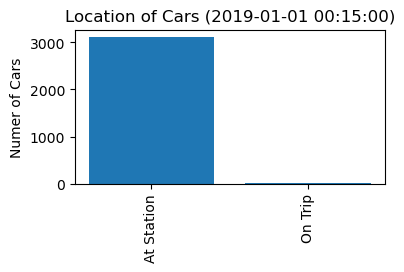

Reward in this step: -8180.224822883687
-------- State at time 2 --------


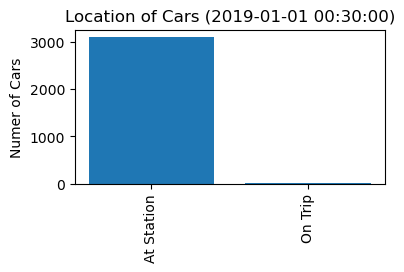

Reward in this step: -7431.392153232993
-------- State at time 3 --------


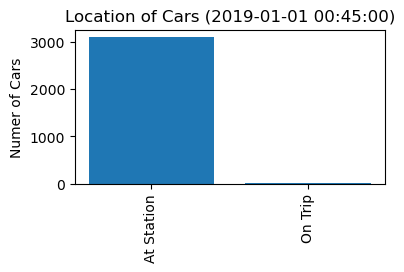

Reward in this step: -6814.805423701953
-------- State at time 4 --------


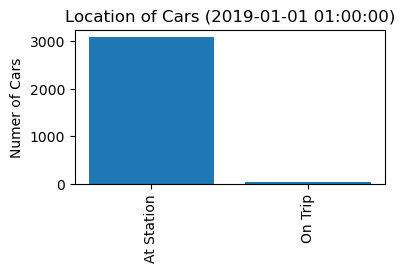

Reward in this step: -5993.3178080016005
-------- State at time 5 --------


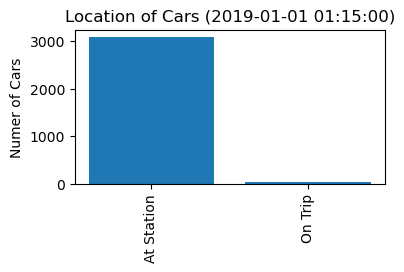

Reward in this step: -5366.4499100479525
-------- State at time 6 --------


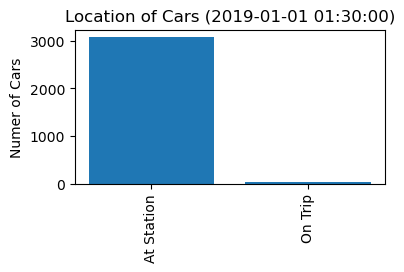

Reward in this step: -4630.593308129336
-------- State at time 7 --------


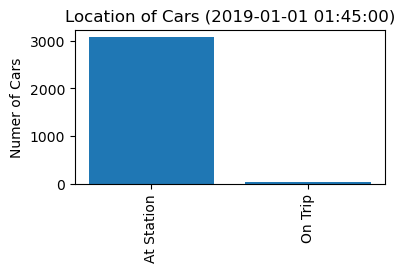

Reward in this step: -4031.6036821768867
-------- State at time 8 --------


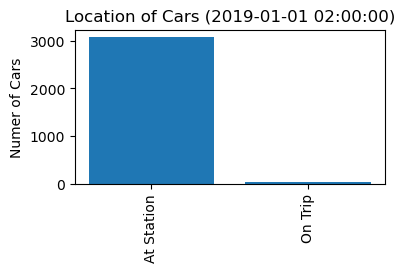

Reward in this step: -3431.311691815254
-------- State at time 9 --------


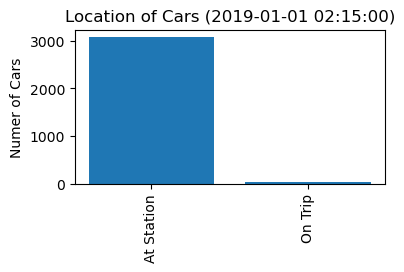

Reward in this step: -2832.0473657004704
-------- State at time 10 --------


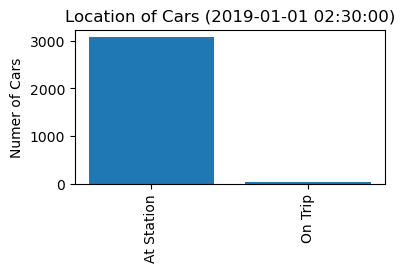

Reward in this step: -2257.445821580094
-------- State at time 11 --------


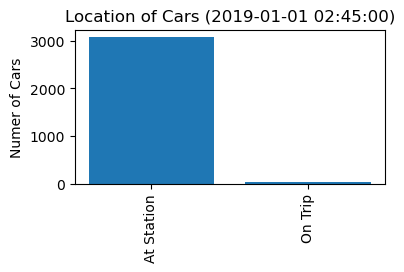

Reward in this step: -1637.5466278658157
-------- State at time 12 --------


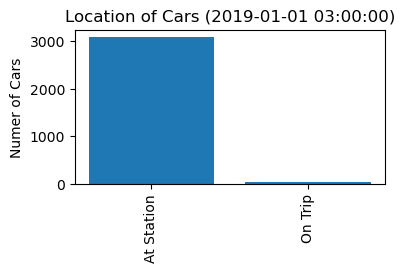

Reward in this step: -1135.6180589656378
-------- State at time 13 --------


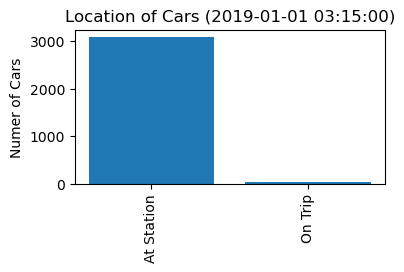

Reward in this step: -479.17726805826373
-------- State at time 14 --------


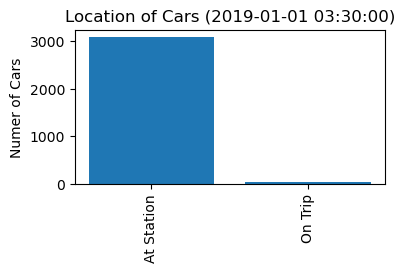

Reward in this step: 174.13981290595473
-------- State at time 15 --------


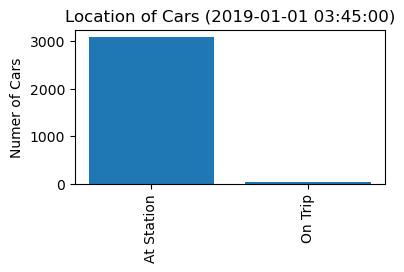

Reward in this step: 314.0232293590117
-------- State at time 16 --------


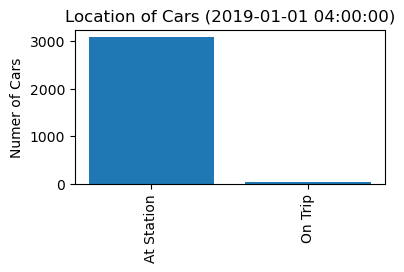

Reward in this step: 318.5
-------- State at time 17 --------


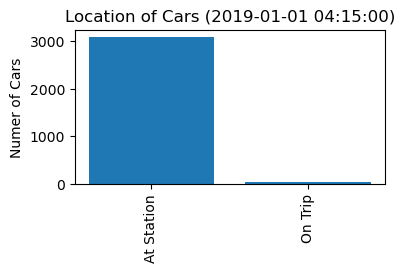

Reward in this step: 322.0076744914716
-------- State at time 18 --------


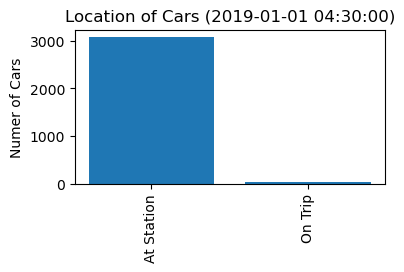

Reward in this step: 353.9058566619094
-------- State at time 19 --------


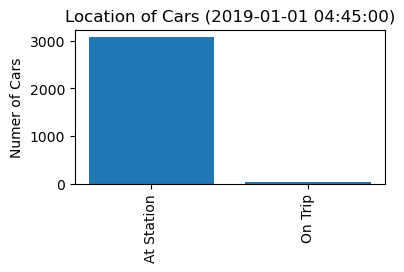

Reward in this step: 366.1244534485936
-------- State at time 20 --------


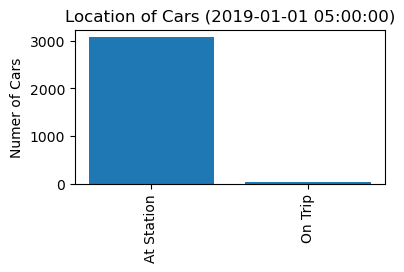

Reward in this step: 350.7745164235688
-------- State at time 21 --------


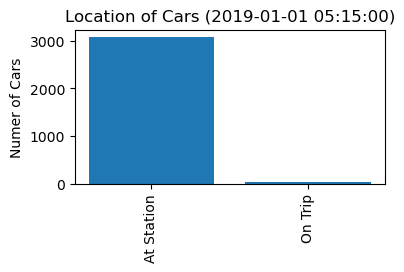

Reward in this step: 354.33872528683514
-------- State at time 22 --------


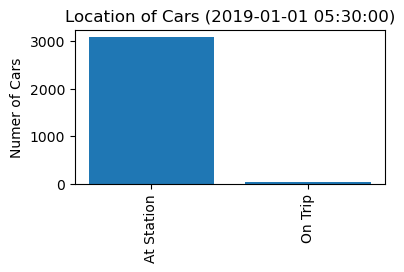

Reward in this step: 283.16732733223836
-------- State at time 23 --------


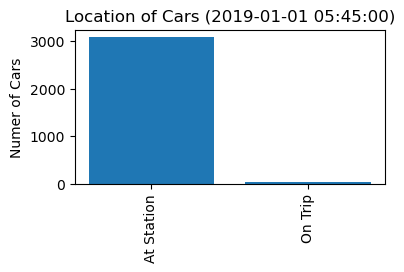

Reward in this step: 293.08670929899563
-------- State at time 24 --------


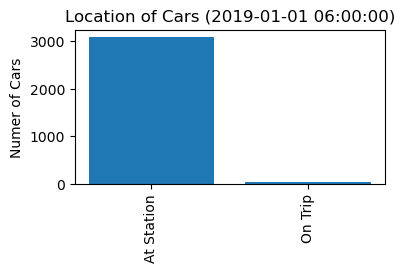

Reward in this step: 301.7421549790403
-------- State at time 25 --------


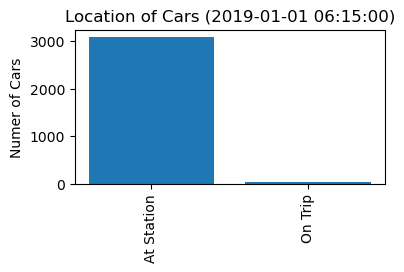

Reward in this step: 305.582352279681
-------- State at time 26 --------


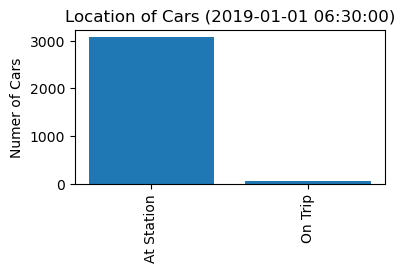

Reward in this step: 403.645
-------- State at time 27 --------


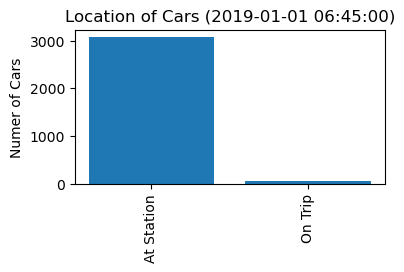

Reward in this step: 411.24153551748594
-------- State at time 28 --------


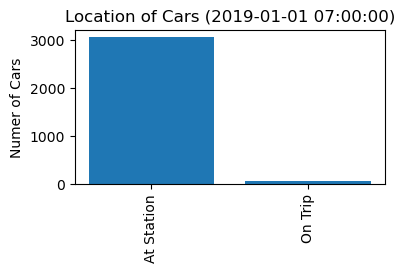

Reward in this step: 503.635
-------- State at time 29 --------


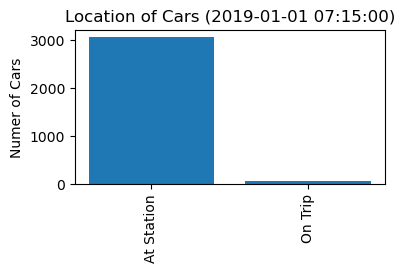

Reward in this step: 510.30499999999995
-------- State at time 30 --------


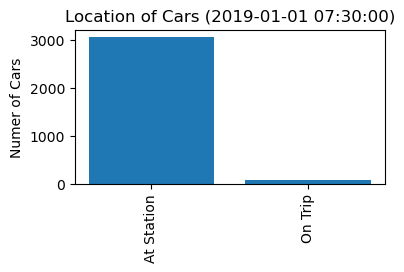

Reward in this step: 582.2503261915649
-------- State at time 31 --------


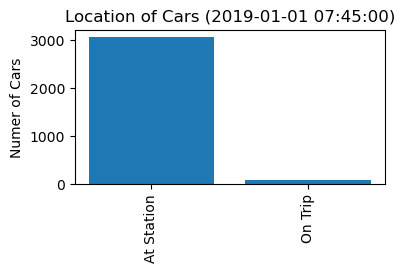

Reward in this step: 588.9795238095238
-------- State at time 32 --------


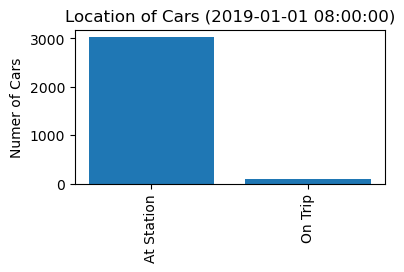

Reward in this step: 839.1193650047281
-------- State at time 33 --------


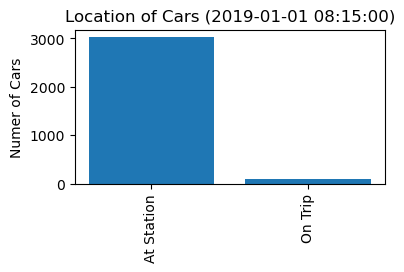

Reward in this step: 845.4608485271252
-------- State at time 34 --------


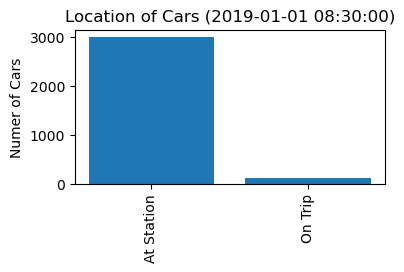

Reward in this step: 1131.815
-------- State at time 35 --------


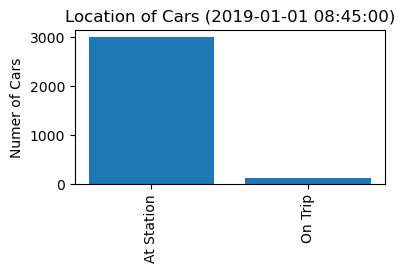

Reward in this step: 1135.4640151988683
-------- State at time 36 --------


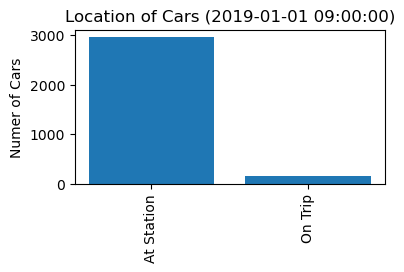

Reward in this step: 1440.250145273811
-------- State at time 37 --------


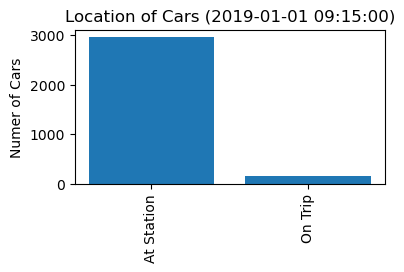

Reward in this step: 1446.75
-------- State at time 38 --------


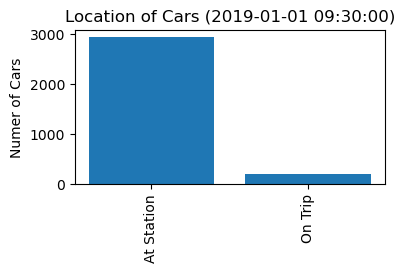

Reward in this step: 1690.675
-------- State at time 39 --------


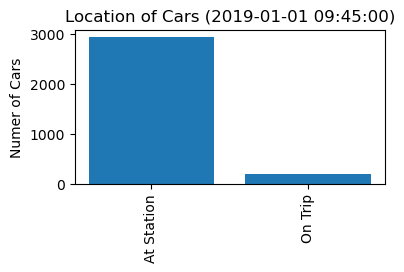

Reward in this step: 1696.3588095238094
-------- State at time 40 --------


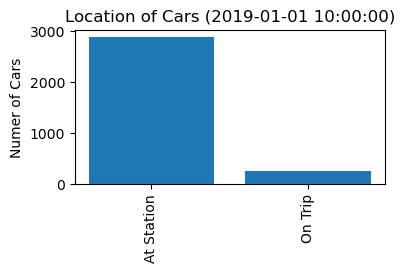

Reward in this step: 2189.486904761905
-------- State at time 41 --------


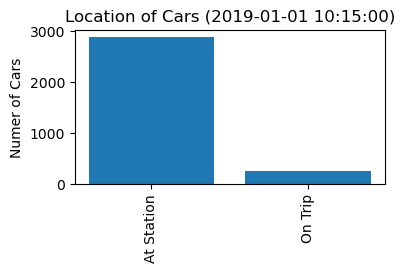

Reward in this step: 2196.429102564103
-------- State at time 42 --------


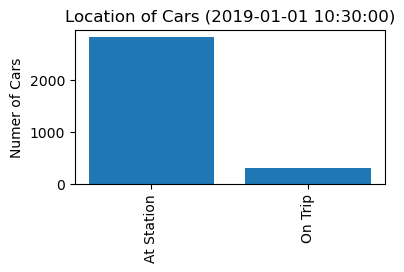

Reward in this step: 2694.852857142857
-------- State at time 43 --------


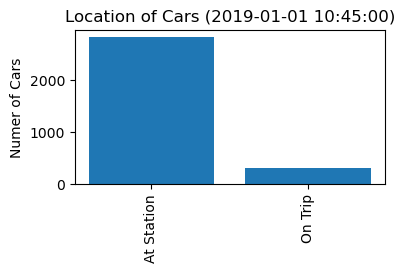

Reward in this step: 2704.4
-------- State at time 44 --------


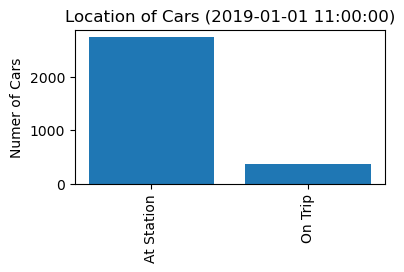

Reward in this step: 3429.289229338547
-------- State at time 45 --------


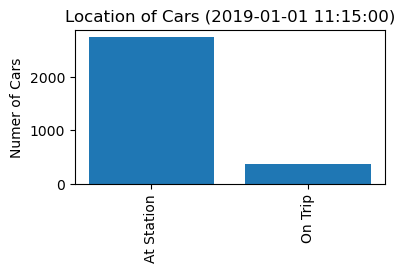

Reward in this step: 3437.36
-------- State at time 46 --------


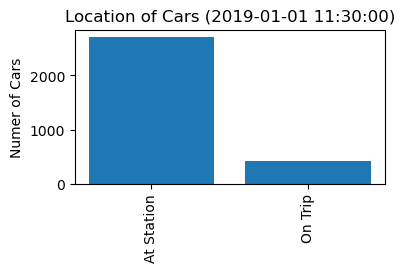

Reward in this step: 3766.362210574996
-------- State at time 47 --------


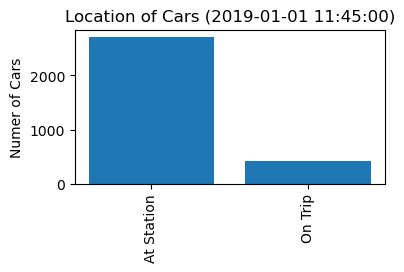

Reward in this step: 3782.286742436966
-------- State at time 48 --------


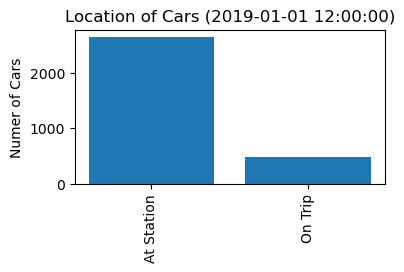

Reward in this step: 4344.579917527362
-------- State at time 49 --------


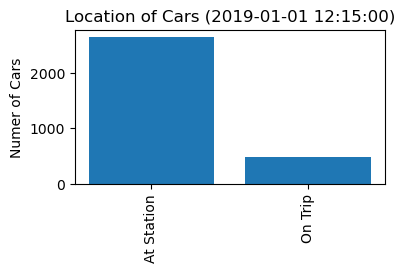

Reward in this step: 4374.283565148452
-------- State at time 50 --------


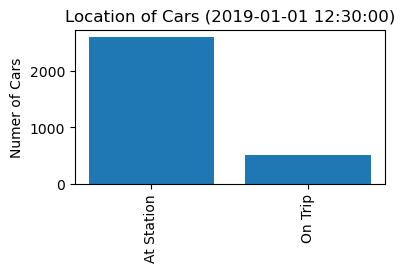

Reward in this step: 4687.645757501515
-------- State at time 51 --------


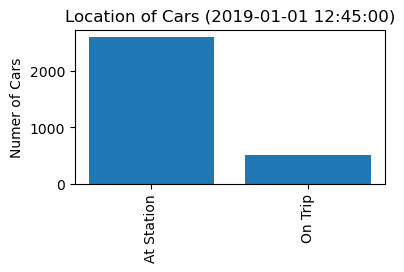

Reward in this step: 4717.432580857853
-------- State at time 52 --------


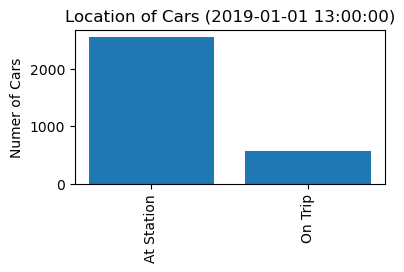

Reward in this step: 5168.797772798344
-------- State at time 53 --------


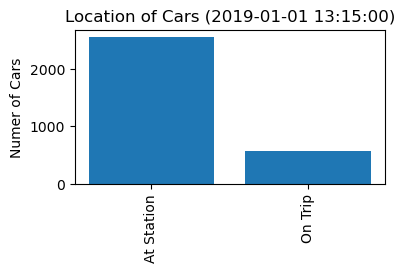

Reward in this step: 5196.875045248868
-------- State at time 54 --------


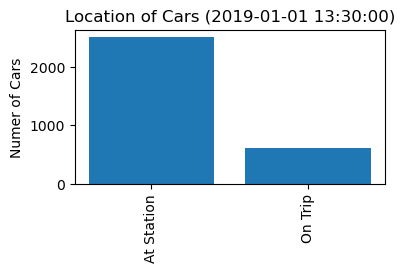

Reward in this step: 5586.144860751457
-------- State at time 55 --------


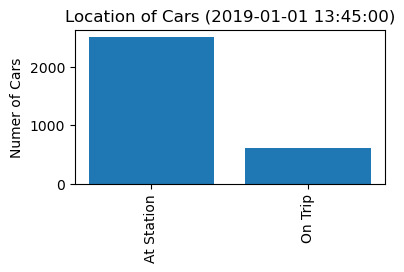

Reward in this step: 5625.990099747005
-------- State at time 56 --------


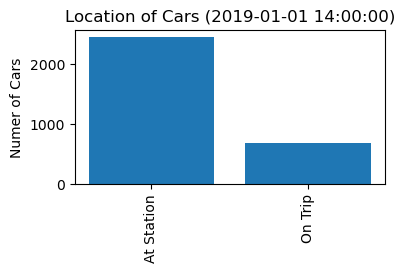

Reward in this step: 6201.807472527473
-------- State at time 57 --------


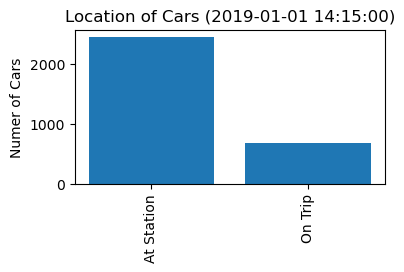

Reward in this step: 6227.31717948718
-------- State at time 58 --------


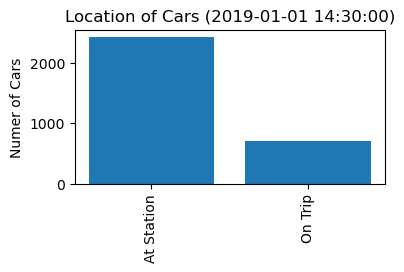

Reward in this step: 6347.008424908425
-------- State at time 59 --------


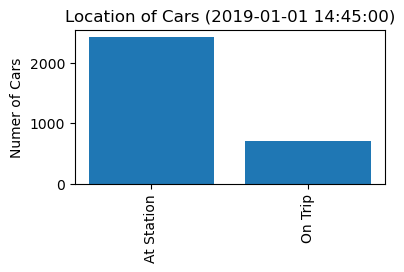

Reward in this step: 6378.551514779959
-------- State at time 60 --------


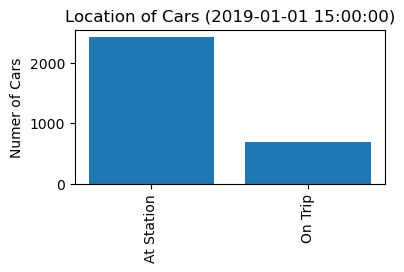

Reward in this step: 6228.5110073260075
-------- State at time 61 --------


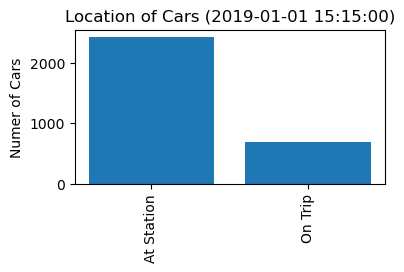

Reward in this step: 6285.381698902605
-------- State at time 62 --------


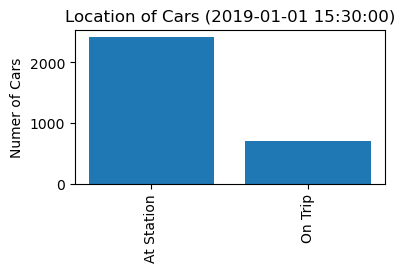

Reward in this step: 6295.097630829425
-------- State at time 63 --------


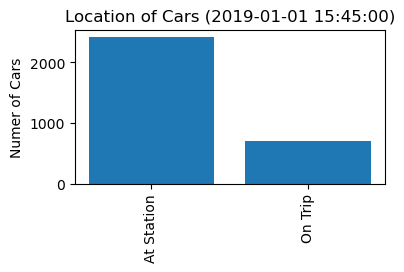

Reward in this step: 6357.746721611722
-------- State at time 64 --------


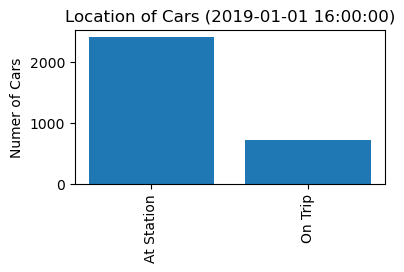

Reward in this step: 6414.22771062271
-------- State at time 65 --------


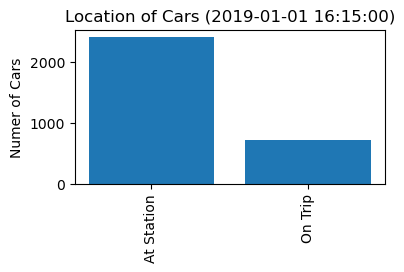

Reward in this step: 6481.921556776557
-------- State at time 66 --------


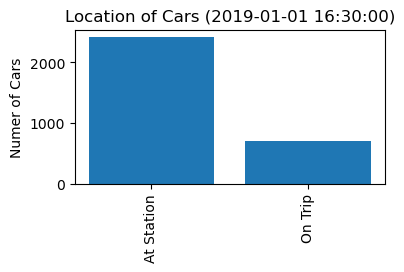

Reward in this step: 6233.481331729273
-------- State at time 67 --------


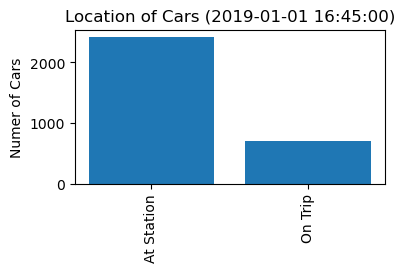

Reward in this step: 6302.312655677655
-------- State at time 68 --------


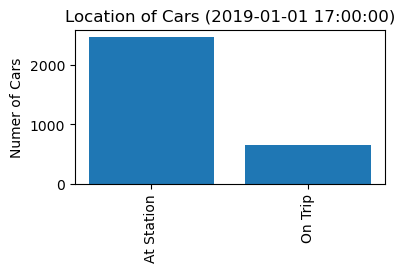

Reward in this step: 5587.704422838351
-------- State at time 69 --------


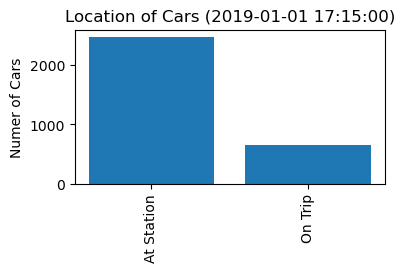

Reward in this step: 5697.55989010989
-------- State at time 70 --------


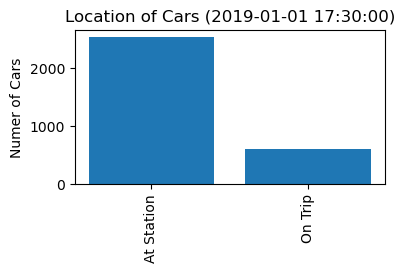

Reward in this step: 5066.566459659245
-------- State at time 71 --------


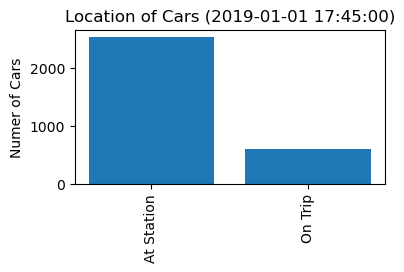

Reward in this step: 5155.352652959442
-------- State at time 72 --------


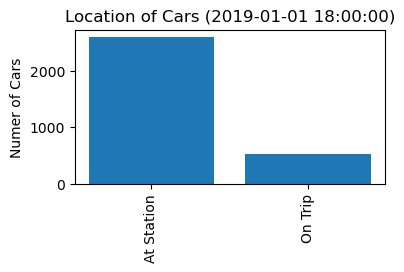

Reward in this step: 4340.052780650722
-------- State at time 73 --------


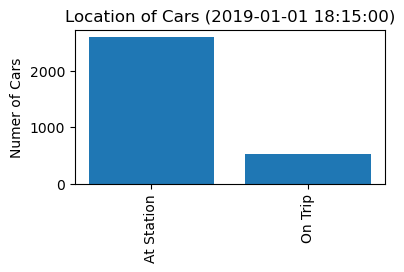

Reward in this step: 4499.870556864645
-------- State at time 74 --------


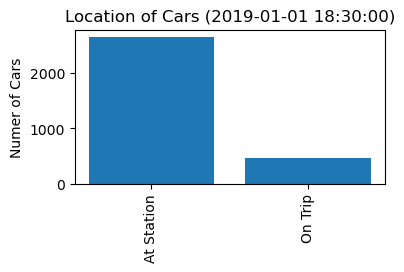

Reward in this step: 3821.387161172161
-------- State at time 75 --------


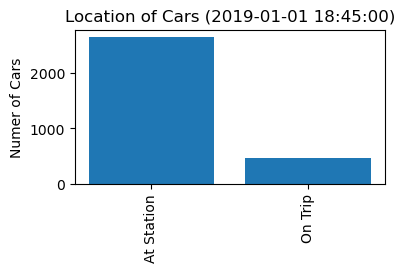

Reward in this step: 3907.0534615384613
-------- State at time 76 --------


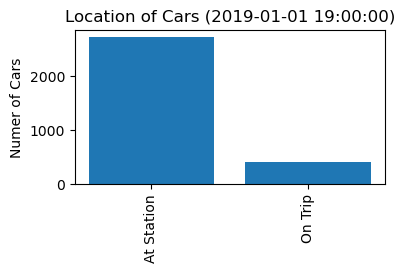

Reward in this step: 3240.450161666914
-------- State at time 77 --------


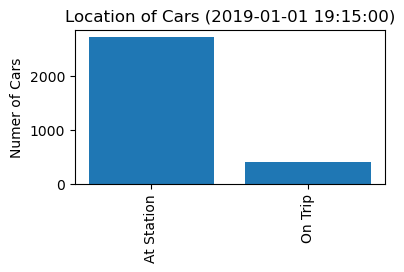

Reward in this step: 3342.3563357728885
-------- State at time 78 --------


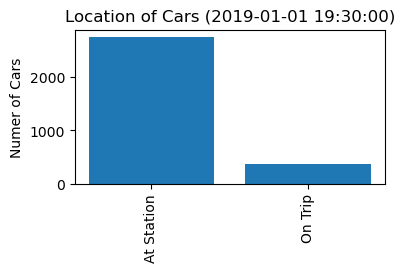

Reward in this step: 2992.245986975987
-------- State at time 79 --------


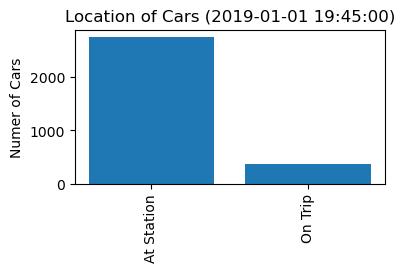

Reward in this step: 3084.763223443223
-------- State at time 80 --------


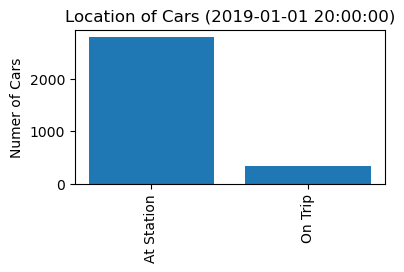

Reward in this step: 2693.886202588327
-------- State at time 81 --------


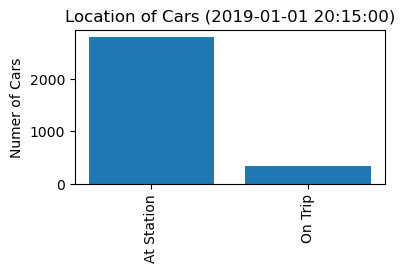

Reward in this step: 2769.4517781350246
-------- State at time 82 --------


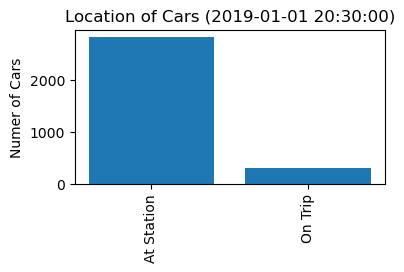

Reward in this step: 2405.498946647874
-------- State at time 83 --------


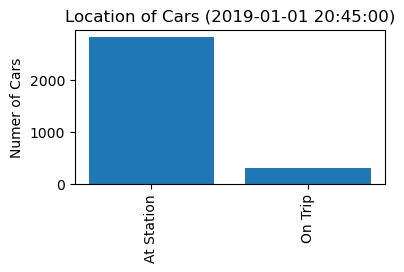

Reward in this step: 2474.301445809093
-------- State at time 84 --------


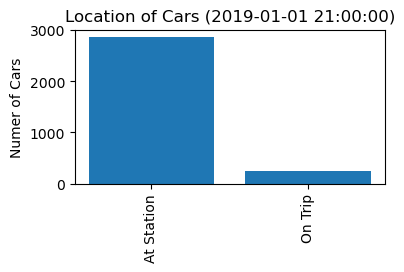

Reward in this step: 2000.831575091575
-------- State at time 85 --------


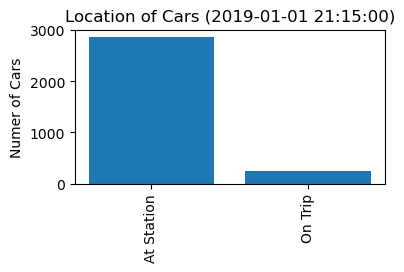

Reward in this step: 2083.8016963647806
-------- State at time 86 --------


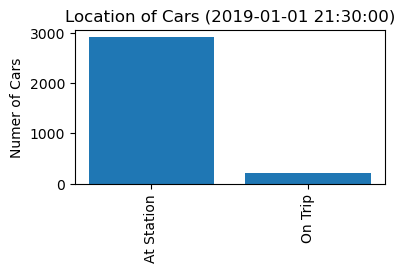

Reward in this step: 1587.9739072039072
-------- State at time 87 --------


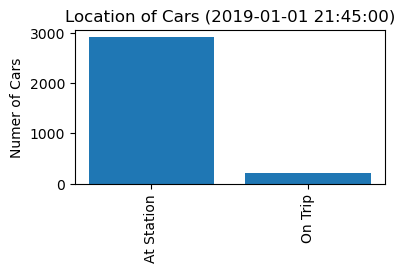

Reward in this step: 1678.722582417582
-------- State at time 88 --------


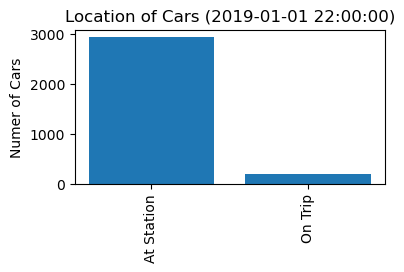

Reward in this step: 1445.2251650716978
-------- State at time 89 --------


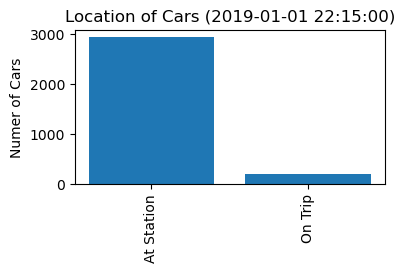

Reward in this step: 1516.1046742528601
-------- State at time 90 --------


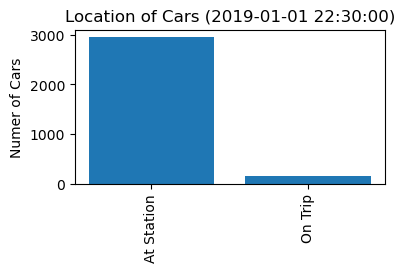

Reward in this step: 1286.4942096280472
-------- State at time 91 --------


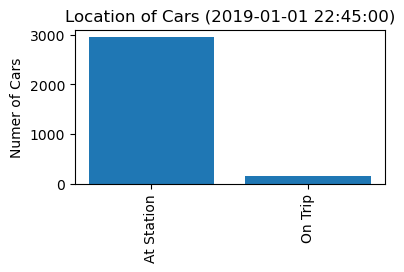

Reward in this step: 1348.2665018315017
-------- State at time 92 --------


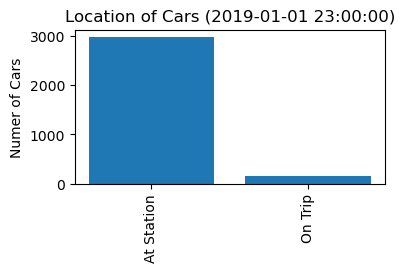

Reward in this step: 1170.8633516483515
-------- State at time 93 --------


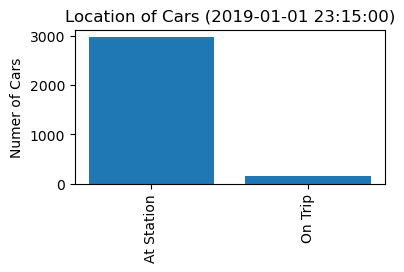

Reward in this step: 1218.3018038684563
-------- State at time 94 --------


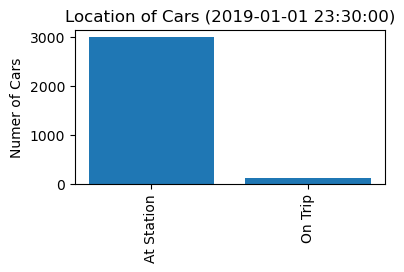

Reward in this step: 984.2506796906795
-------- State at time 95 --------


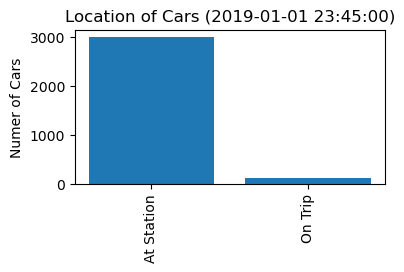

Reward in this step: 1015.1787484737483
-------- State at time 96 --------


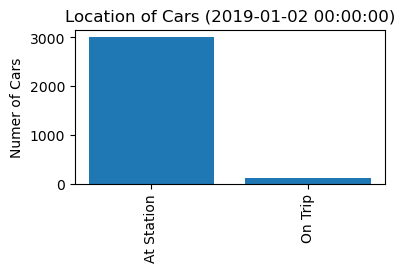

Reward in this step: 908.2700671550671
['00:15', '00:30', '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15', '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00', '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45', '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30', '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15', '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:15', '23:30', '23:45', '00:00']


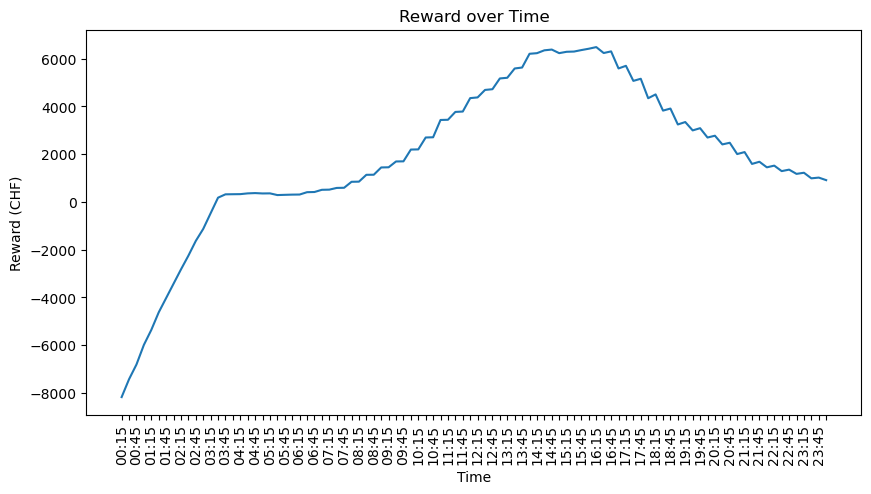

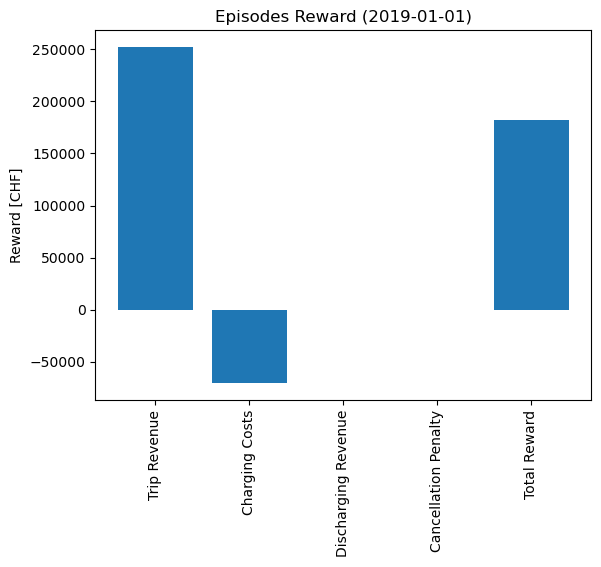

In [24]:
# number of days to simulate 
nr_iterations = 1

# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex
env = CarsharingEnv(stations, nr_vehicles = 4233)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0

# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql = "SELECT * FROM msc_2023_dominik.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)

    # get vehicle IDs
    vehicle_list = data.iloc[:,1].tolist()
    
    # count number of vehicles
    nr_vehicles = data.shape[0]
    
    # boolean if last day of a week
    end_of_week = False
    
    # iteration for each day
    for day in range(99,676,96):
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date = pd.to_datetime(data.columns[day-97])
        
        # get timestamp of first reservation of next day
        last_timestamp = date + pd.Timedelta(days=1)
        last_timestamp = pd.Timestamp(last_timestamp.date())
       
        # load reservations of current day, create indices
        sql = "SELECT * FROM msc_2023_dominik.reservations_discrete WHERE reservationfrom_discrete_date = '{}' or reservationfrom_discrete = '{}' ORDER BY reservationfrom_discrete".format(date, last_timestamp)
        reservations = pd.read_sql(sql, engine)
        reservations.set_index(['vehicle_no', 'reservationfrom_daytime', 'syscreatedate_daytime'], inplace=True, drop=False)

        # get discete data of day
        dayly_data = data.iloc[:,day-97:day]
        
        # reset day at begining of new episode (day)
        s = env.reset(dayly_data, vehicle_list, reservations, last_timestamp, end_of_week)
        
        # last day of a week
        if day == 675:
            end_of_week = True
            print("End of Week")
        
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            ### action ###
            act = np.ones(nr_vehicles)# always charge all vehicles
            # act = np.full(nr_vehicles, 2) # always discharge all vehicles
            # act = np.zeros(nr_vehicles) # do nothing
            
            # proceed one time step
            s, rew, dayly_data, done, _ = env.step(act, dayly_data, reservations, stations, end_of_week, last_timestamp)
            
            # get timestep statistics 
            env.render(dayly_data)
            print("Reward in this step:", rew)
            counter +=1
        
        # summary statistics of episode (day)
        env.episode_summary_statistics(dayly_data)
        count += 1

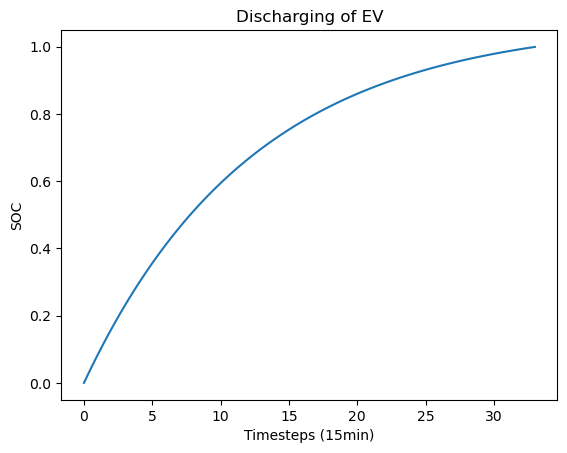

In [65]:
import matplotlib.pyplot as plt
import numpy as np

def f(c, p, t):
    return (1 - np.exp(-t * 0.6 / (c/p))) * 1.075
def reflected_f(c, p, t):
     return (1 - np.exp(t * 0.6 / (c/p))) * 0.07514760980634634
    


c = 82  # kWh
p = 11  # kW
t = np.linspace(0, 33, 100)

f_t = f(c, p, t)
f_t = f(c, p, t)

plt.plot(t, f_t)
plt.xlabel('Timesteps (15min)')
plt.ylabel('SOC')
plt.title('Discharging of EV')
plt.show()